# Heat Transport
This breaks down the contribution to atmospheric heat transport.

In [1]:
import copy
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import numpy as np
import matplotlib.pyplot as plt
import numpy_indexed.index
import xarray as xr
import scipy.optimize
from tqdm import tqdm
from scipy import integrate
# Use custom matplotlib style for publishing
plt.style.use(os.environ['PWD']+'/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')
import matplotlib
# matplotlib.rcParams['lines.linewidth'] = 1.2          # make lines bigger for presentation

In [2]:
import isca_tools
from isca_tools.utils.moist_physics import moist_static_energy, sphum_sat
from isca_tools.utils.circulation import get_u_thermal
from isca_tools.utils.constants import g, R, radius_earth, rot_earth
from isca_tools.utils import area_weighting, annual_time_slice
from isca_tools.utils.ds_slicing import annual_mean, time_rolling
from isca_tools.utils.radiation import frierson_net_toa_sw_dwn

In [3]:
def get_aht_decomp_integrand(mse, v, n_days_av, n_day_year=360):
    # n_days_av is the number of days to average over in the time dimension
    n_years = int(mse.time.size / n_day_year)
    if np.round(mse.time.size / n_day_year) != n_years:
        raise ValueError('Not whole number of years in dataset')
    
    def time_av(x, time_ax=0):
        x_av = time_rolling(annual_mean(x), n_days_av)
        # Tile array so will be of same number of years as initial dataset - each year is equivalent though
        n_repeats = np.ones(len(x_av.shape), dtype=int)
        n_repeats[time_ax] = n_years
        return np.tile(x_av, n_repeats) * x**0        # multiply by x**0 so has correct dimensions

    mse_av = time_av(mse).mean(dim='lon')
    v_av = time_av(v).mean(dim='lon')
    
    # Meridional Overtuning Circulation - average in time first and then take zonal average
    aht_moc = mse_av * v_av
        
    # Stationary Eddies - departure from the zonal average
    aht_se = ((time_av(mse)-mse_av) * (time_av(v) - v_av)).mean(dim='lon')
    
    # Transient Eddies - take deviation from time, zonal average. Then average over time first before zonal average
    aht_te = time_av((mse-mse_av) * (v-v_av)).mean(dim='lon')
    
    # Transient Overturning Circulation - departure from temporal mean
    aht_toc = time_av((mse.mean(dim='lon') - mse_av) * (v.mean(dim='lon') - v_av))
    return aht_moc, aht_se, aht_te, aht_toc

In [26]:
# Load dataset - at surface and in free troposphere
use_time_start = 360*2

# Load dataset
exp_dir = 'rossbypalooza/lat_20/'
exp_names = ['1']
time_start = 360
# time_final = 9999999999999999
# exp_dir = 'rossbypalooza/depth=20/all_nh/lat_10/'
# # exp_names = ['base', 'rot_4x']
# exp_names = ['base']
# time_start = 0
# exp_dir = 'tau_sweep/aquaplanet/depth=1/'
# exp_names = ['k=1']
# time_start = 360*2

time_final = 9999999999999999
# day_plot = None         # if None, will plot annual mean, else will plot on specific day with the below smoothing
day_plot = 5*30+20   # 2 cell regime
# day_plot = 8*30+10   # 3 cell regime
# day_plot = 6*30+26     # Time of max Hadley cell extent
aht_n_days_av = 20      # Number of days to average over when computing temporal mean in AHT calculation
smooth_ndays = 20       # take rolling average in time dimension over this many days


# only keep variables required to compute relative humidity and MSE
var_keep = ['temp', 'sphum', 'height', 't_surf', 'vcomp', 'ucomp', 'swdn_toa', 'swdn_sfc', 'olr', 'ps']

# exp_names = ['Aquaplanet', 'Constant conductivity', 'Bucket', 'Bucket - $C_V$']
# exp_dir = ['tau_sweep/aquaplanet/', 'tau_sweep/land/meridional_band/evap/', 'tau_sweep/land/meridional_band/bucket/',
#            'tau_sweep/land/meridional_band/bucket_evap/evap=0_1/']
# color_seq_exp = ['b', 'g', 'orange', 'r']
# rot_rate = [1, 2]
n_exp = len(exp_names)
ds_base = []
ds = []
albedo = []
tau_sw = []
tau_lw = []
omega = []
with tqdm(total=n_exp, position=0, leave=True) as pbar:
    for j in range(n_exp):
        namelist = isca_tools.load_namelist(exp_dir + exp_names[j])  # Need this for albedo_value
        albedo += [namelist['mixed_layer_nml']['albedo_value']]
        tau_sw += [namelist['two_stream_gray_rad_nml']['atm_abs']]
        tau_lw += [namelist['two_stream_gray_rad_nml']['odp']]
        try:
            omega += [namelist['constants_nml']['omega']]
        except KeyError:
            omega += [rot_earth]  # default earth value
        
        ds_base += [isca_tools.load_dataset(exp_dir + exp_names[j]).sel(time=slice(time_start, time_final))[var_keep]]
        
        ds_use = ds_base[j]
        ds_use['mse'] = moist_static_energy(ds_use.temp, ds_use.sphum, ds_use.height)*1000
        # AHT decomposition into different terms
        ds_use['aht_moc'], ds_use['aht_se'], ds_use['aht_te'], ds_use['aht_toc'] = \
            get_aht_decomp_integrand(ds_use.mse.load(), ds_use.vcomp.load(), aht_n_days_av)
        ds_use['swdn_toa_net'] = frierson_net_toa_sw_dwn(ds_use.swdn_toa, ds_use.ps, albedo[j], tau_sw[j])
        # ds_use['swdn_toa_net'] = ds_use.swdn_toa - albedo[j]/(1-albedo[j]) * ds_use.swdn_sfc        # gives the same answer as toa_net
        ds_use = annual_mean(ds_use).mean(dim='lon')        # only keep annual mean
        if day_plot is None:
            ds_use = ds_use.mean(dim='time')
        else:
            ds_use = time_rolling(ds_use, smooth_ndays).sel(time=day_plot, method='nearest')
        ds += [ds_use.load()]          
        pbar.update(1)
omega = np.asarray(omega)        
n_pressure = ds[0].pfull.size

100%|██████████| 1/1 [00:47<00:00, 47.36s/it]


In [27]:
# If true, will save all figures to desktop - option to save specific figures later on.
save_fig = False
# if publishing figure, use high dpi
publish_fig = True

ar = 4/3        # aspect ratio (width/height)
# Details required for Journal of Climate Figures
low_dpi = 100
dpi = {'monochrome': 1100, 'combination': 800, 'halftone': 300}
width = {'one_col': 3.2, 'two_col': 5.5}        # width in inches 
save_pad_inches = 0.05
im_sz = 1.5
ax_linewidth = plt.rcParams['axes.linewidth']

# Default parameters
omega_earth_multiple = ['{:g}'.format(float('{:.2g}'.format(i))) for i in omega/rot_earth]      # multiple of earths rotation rate
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors_aht = {'moc': default_colors[0], 'se': default_colors[2], 'te': default_colors[3], 'toc': default_colors[1], 'total': 'k'}
color_exp = []
linestyles_exp = []
for i in range(n_exp):
    if omega_earth_multiple[i]=='1':
        color_exp += ['k']
        linestyles_exp += ['-']
    elif float(omega_earth_multiple[i])<1:
        color_exp += [default_colors[0]]
        if n_exp > 2:
            linestyles_exp += ['--']
        else:
            linestyles_exp += [':']
    else:
        color_exp += [default_colors[3]]
        linestyles_exp += [':']

# month_ticks = (np.arange(15,12*30+15,30), ['J','F','M','A','M','J','J','A','S','O','N','D'])
month_names = ['January','February','March','April','May','June','July','August','September','October','November','December']
if day_plot is None:
    label_date = 'Annual Mean'
else:
    label_date = f"{month_names[int(np.floor(day_plot/30))]} {int(np.median(day_plot)%30+1)}"

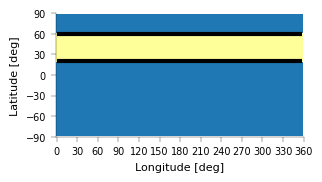

In [28]:
# Show where the land is
save_land_fig = False

job_dir = os.path.join(os.path.dirname(os.environ['GFDL_DATA']), 'jobs')
land_file_name = os.path.join(job_dir, exp_dir, exp_names[0], 'land.nc')
is_land_data = os.path.exists(land_file_name)
if is_land_data:
    fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
    isca_tools.plot.show_land(land_file_name, fig=fig, ax=ax)
    lat_land = isca_tools.utils.land.get_land_coords(land_file=land_file_name)[0]       # get the longitude coordinates of land
    lat_land_min = float(lat_land.min())
    lat_land_max = float(lat_land.max())
    lat_land_ind = np.where(ds[0].lat>=lat_land_min-0.5)[0]
    lat_land_ind = lat_land_ind[np.where(ds[0].lat[lat_land_ind]<=lat_land_max+0.5)[0]]
    if save_fig or save_land_fig:
        fig.savefig(f"/Users/joshduffield/Desktop/land_coords.pdf",
                    dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)
else:
    lat_land_min = None
    lat_land_max = None
    lat_land_ind = None

def show_land(ax, lat_land_min=lat_land_min, lat_land_max=lat_land_max, lat_ax='x', color_land='g', lw_land=4):
    if is_land_data:
        if not isinstance(ax, (list, np.ndarray)):
            raise ValueError(f'ax should be a list or numpy array, but given is {type(ax)}')
        for i in range(len(ax)):
            if lat_ax == 'x':
                var = ax[i].get_ylim()[0]
                xlim = ax[i].get_xlim()
                ax[i].hlines(var, lat_land_min, lat_land_max, color=color_land, lw=lw_land)
                ax[i].set_ylim(var, ax[i].get_ylim()[1])
                ax[i].set_xlim(xlim)
            elif lat_ax == 'y':
                var = ax[i].get_xlim()[0]
                ylim = ax[i].get_ylim()
                ax[i].vlines(var, lat_land_min, lat_land_max, color=color_land, lw=lw_land)
                ax[i].set_xlim(var, ax[i].get_xlim()[1])
                ax[i].set_ylim(ylim)
            else:
                raise ValueError(f'lat_ax must be either x or y, but {lat_ax} was given.')

## Atmospheric Heat Transport (AHT)
Below I plot AHT as a function of latitude using equation 2 from Donohoe 2020 paper.

In [29]:
def get_aht_from_radiation(swdn_toa_net, olr, lat, radius=radius_earth):
    if swdn_toa_net.shape[0] != lat.size:
        raise ValueError(f'Expect first axis to be latitude but there are {lat.shape} latitude coordinates '
                         f'and the first axis has {olr.shape[0]} values')
    aht = np.zeros_like(swdn_toa_net)       
    integrand = np.cos(np.deg2rad(lat)) * (swdn_toa_net - olr)
    for i in range(lat.size):       # assumes latitude is 1st axis
        aht[i] = integrate.trapz(integrand[i:], np.deg2rad(lat[i:]), axis=0)
    return -2*np.pi*radius**2*aht

def aht_integral(v_mse_product, pressure, lat, radius=radius_earth, ax_pressure=0):
    # Looks weird with simpson integral
    return 2*np.pi*radius*np.cos(np.deg2rad(lat))/g*integrate.trapz(v_mse_product, x=pressure, axis=ax_pressure)

sw_var_use = 'swdn_toa_net'
for i in range(n_exp):
    # plot seems better if I use insolation rather than net TOA SW radiation for some reason
    ds[i]['aht'] = get_aht_from_radiation(ds[i][sw_var_use]-area_weighting(ds[i][sw_var_use]).mean(dim='lat'), 
                                          ds[i].olr-area_weighting(ds[i].olr).mean(dim='lat'), ds[i].lat) * ds[i].swdn_toa**0
    ds[i]['aht_comp_sum'] = aht_integral(ds[i]['aht_moc']+ds[i]['aht_te']+ds[i]['aht_se']+ds[i]['aht_toc'], ds[i].pfull*100, ds[i].lat)

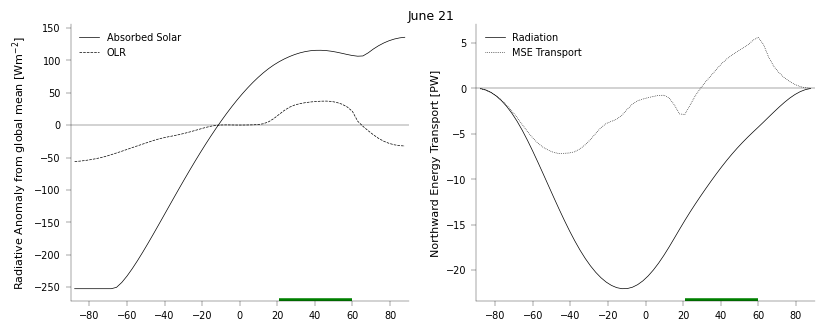

In [30]:
# save_mse_amp_timeseries_fig = False
fig, ax = plt.subplots(1, 2, figsize=(im_sz*2*width['one_col'], im_sz*width['one_col']/ar), sharex=True)
for i in range(n_exp):
    ax[0].plot(ds[i].lat, ds[i][sw_var_use]-area_weighting(ds[i][sw_var_use]).mean(dim='lat'), color=color_exp[i], 
               label='Absorbed Solar' if i==0 else None)
    ax[0].plot(ds[i].lat, ds[i].olr-area_weighting(ds[i].olr).mean(dim='lat'), color=color_exp[i], linestyle='--', label='OLR' if i==0 else None)
    ax[1].plot(ds[i].lat, ds[i].aht/10**15, color=color_exp[i], label=omega_earth_multiple[i] if n_exp>1 else 'Radiation')
    ax[1].plot(ds[i].lat, ds[i].aht_comp_sum/10**15, color=color_exp[i], linestyle=':', label='MSE Transport' if n_exp==1 else None)
ax[0].legend()
ax[1].legend(title='$\Omega$' if n_exp>1 else None)
ax[0].set_xlim(-90, 90)
ax[0].axhline(0, color='k', lw=ax_linewidth)
ax[1].axhline(0, color='k', lw=ax_linewidth)
ax[0].set_ylabel('Radiative Anomaly from global mean [Wm$^{-2}$]')
ax[1].set_ylabel('Northward Energy Transport [PW]')
show_land(ax, lat_ax='x')
fig.suptitle(label_date, fontsize=9, y=0.92);
# if save_mse_amp_timeseries_fig:
#     fig.savefig(f"/Users/joshduffield/Desktop/mse_amp_timeseries.pdf", 
#                 dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

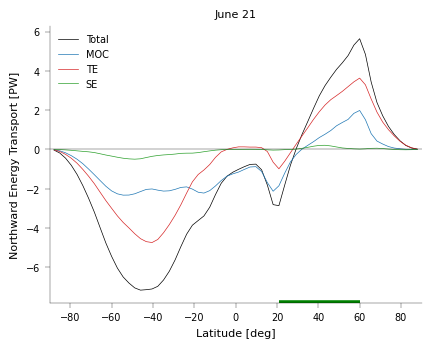

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(im_sz*width['one_col'], im_sz*width['one_col']/ar))
for i in range(n_exp):
    ax.plot(ds[i].lat, ds[i]['aht_comp_sum']/10**15, color=colors_aht['total'], linestyle=linestyles_exp[i], label='Total' if i==0 else None)
    for key in ['moc', 'te', 'se']:
        ax.plot(ds[i].lat, aht_integral(ds[i][f'aht_{key}']/10**15, ds[i].pfull*100, ds[i].lat), color=colors_aht[key], 
                linestyle=linestyles_exp[i], label=key.upper() if i==0 else None)
ax.legend()
ax.set_xlim(-90, 90)
ax.axhline(0, color='k', lw=ax_linewidth)
show_land([ax], lat_ax='x')
ax.set_ylabel('Northward Energy Transport [PW]')
ax.set_xlabel('Latitude [deg]')
ax.set_title(label_date);